In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import math
import pandas as pd
import datetime as dt
import sys
import configparser
import PIL
from PIL import Image
import subprocess
import micaplotutils as plotutils
import micametadata as metadata
import micautils as msutils
import pyexiv2

In [2]:
def load_panel_factors(panel_cal_fn):
    panel_cal = pd.read_csv(panel_cal_fn, index_col='band_name').squeeze()
    panel_cal.name = panel_cal_fn
    return panel_cal

In [3]:
def panelimage(panel_cal, image_name, image_path, plot_steps=False):

    image = os.path.join(image_path, image_name)
	# Read raw image DN values
	# reads 16 bit tif
    imageRaw = plt.imread(image)

	# Display the image
    if plot_steps:
        fig, ax = plt.subplots(figsize=(8,6))
        ax.imshow(imageRaw, cmap='gray')
        plt.show()
        fig = plotutils.plotwithcolorbar(imageRaw, title='Raw image values with colorbar')

	# Load metadata
    meta = metadata.Metadata(image)
    cameraMake = meta.get_item('EXIF:Make')
    cameraModel = meta.get_item('EXIF:Model')
    bandName = meta.get_item('XMP:BandName')

	# Correct the image of refl panel
    radianceImage, L, V, R = msutils.raw_image_to_radiance(meta, imageRaw)
    if plot_steps:
        plotutils.plotwithcolorbar(V,'Vignette Factor')
        plotutils.plotwithcolorbar(R,'Row Gradient Factor')
        plotutils.plotwithcolorbar(V*R,'Combined Corrections')
        plotutils.plotwithcolorbar(L,'Vignette and row gradient corrected raw values')

	# Display the corrected refl panel image
    plotutils.plotwithcolorbar(radianceImage,'All factors applied and scaled to radiance')

In [4]:
def radrefl_factor(panel_cal, first_image_name,second_image_name,image_path, ulx1, uly1, lrx1, lry1,ulx2,uly2,lrx2,lry2, plot_steps=False,cal_model_fn=None, return_date=False):
    image1 = os.path.join(image_path, first_image_name)
	# Read raw image DN values
	# reads 16 bit tif - this will likely not work for 12 bit images
    imageRaw1 = plt.imread(image1)

	# Display the image
    if plot_steps:
        fig, ax = plt.subplots(figsize=(8,6))
        ax.imshow(imageRaw, cmap='gray')
        plt.show()
        fig = plotutils.plotwithcolorbar(imageRaw1, title='Raw image values with colorbar')

	# Load metadata
    meta1 = metadata.Metadata(image1)
    cameraMake = meta1.get_item('EXIF:Make')
    cameraModel = meta1.get_item('EXIF:Model')
    bandName = meta1.get_item('XMP:BandName')
    
	# Correct the image of refl panel
    radianceImage1, L, V, R = msutils.raw_image_to_radiance(meta1, imageRaw1)
    if plot_steps:
        plotutils.plotwithcolorbar(V,'Vignette Factor')
        plotutils.plotwithcolorbar(R,'Row Gradient Factor')
        plotutils.plotwithcolorbar(V*R,'Combined Corrections')
        plotutils.plotwithcolorbar(L,'Vignette and row gradient corrected raw values')

	# Mark points on image
    markedImg1 = radianceImage1.copy()
    ulx1 = ulx1
    uly1 = uly1
    lrx1 = lrx1
    lry1 = lry1

		# Plot rectangle on image
    cv2.rectangle(markedImg1,(ulx1,uly1),(lrx1,lry1),(0,255,0),3)
    plotutils.plotwithcolorbar(markedImg1, 'Panel region in radiance image')

	# Select panel region from radiance image
    panelRegion1 = radianceImage1[lry1:uly1, ulx1:lrx1]
    meanRadiance1 = panelRegion1.mean()
    print('Mean Radiance in panel region: {:1.3f} W/m^2/nm/sr'.format(meanRadiance1))
    panelReflectance1 = panel_cal.loc[bandName].factor
    radianceToReflectance1 = panelReflectance1 / meanRadiance1
    print('Radiance to reflectance conversion factor: {:1.3f}'.format(radianceToReflectance1))

	# Create reflectance image
    reflectanceImage1 = radianceImage1 * radianceToReflectance1
    if plot_steps:
        plotutils.plotwithcolorbar(reflectanceImage1, 'Converted Reflectance Image')

	# Blur the panel to check for trends - we want a consistent reflectance
    panelRegionRefl1 = reflectanceImage1[lry1:uly1,ulx1:lrx1]
    panelRegionReflBlur1 = cv2.GaussianBlur(panelRegionRefl1,(55,55),5)
    plotutils.plotwithcolorbar(panelRegionReflBlur1, 'Smoothed panel region in reflectance image')
    print('Min Reflectance in panel region: {:1.2f}'.format(panelRegionRefl1.min()))
    print('Max Reflectance in panel region: {:1.2f}'.format(panelRegionRefl1.max()))
    print('Mean Reflectance in panel region: {:1.2f}'.format(panelRegionRefl1.mean()))
    print('Standard deviation in region: {:1.4f}'.format(panelRegionRefl1.std()))
    
    image2 = os.path.join(image_path, second_image_name)
	# Read raw image DN values
	# reads 16 bit tif - this will likely not work for 12 bit images
    imageRaw2 = plt.imread(image2)

	# Display the image
    if plot_steps:
        fig, ax = plt.subplots(figsize=(8,6))
        ax.imshow(imageRaw, cmap='gray')
        plt.show()
        fig = plotutils.plotwithcolorbar(imageRaw2, title='Raw image values with colorbar')

	# Load metadata
    meta2 = metadata.Metadata(image2)
    cameraMake = meta2.get_item('EXIF:Make')
    cameraModel = meta2.get_item('EXIF:Model')
    bandName = meta2.get_item('XMP:BandName')
    
	# Correct the image of refl panel
    radianceImage2, L, V, R = msutils.raw_image_to_radiance(meta2, imageRaw2)
    if plot_steps:
        plotutils.plotwithcolorbar(V,'Vignette Factor')
        plotutils.plotwithcolorbar(R,'Row Gradient Factor')
        plotutils.plotwithcolorbar(V*R,'Combined Corrections')
        plotutils.plotwithcolorbar(L,'Vignette and row gradient corrected raw values')

	# Mark points on image
    markedImg2 = radianceImage2.copy()
    ulx2 = ulx2
    uly2= uly2
    lrx2 = lrx2
    lry2 = lry2

		# Plot rectangle on image
    cv2.rectangle(markedImg2,(ulx2,uly2),(lrx2,lry2),(0,255,0),3)
    plotutils.plotwithcolorbar(markedImg2, 'Panel region in radiance image')

	# Select panel region from radiance image
    panelRegion2 = radianceImage2[lry2:uly2, ulx2:lrx2]
    meanRadiance2 = panelRegion2.mean()
    print('Mean Radiance in panel region: {:1.3f} W/m^2/nm/sr'.format(meanRadiance2))
    panelReflectance2 = panel_cal.loc[bandName].factor
    radianceToReflectance2 = panelReflectance2 / meanRadiance2
    print('Radiance to reflectance conversion factor: {:1.3f}'.format(radianceToReflectance2))

	# Create reflectance image
    reflectanceImage2 = radianceImage2 * radianceToReflectance2
    if plot_steps:
        plotutils.plotwithcolorbar(reflectanceImage2, 'Converted Reflectance Image')

	# Blur the panel to check for trends - we want a consistent reflectance.
    panelRegionRefl2 = reflectanceImage2[lry2:uly2, ulx2:lrx2]
    panelRegionReflBlur2 = cv2.GaussianBlur(panelRegionRefl2,(55,55),5)
    plotutils.plotwithcolorbar(panelRegionReflBlur1, 'Smoothed panel region in reflectance image')
    print('Min Reflectance in panel region: {:1.2f}'.format(panelRegionRefl2.min()))
    print('Max Reflectance in panel region: {:1.2f}'.format(panelRegionRefl2.max()))
    print('Mean Reflectance in panel region: {:1.2f}'.format(panelRegionRefl2.mean()))
    print('Standard deviation in region: {:1.4f}'.format(panelRegionRefl2.std()))

    meanradiancetoReflectance = ((radianceToReflectance1 + radianceToReflectance2)/2)
    
    if return_date:
		# Get time of image acquisition
        create_date2 = dt.datetime.strptime(meta2.get_item('EXIF:CreateDate'), '%Y:%m:%d %H:%M:%S')
        create_date1 = dt.datetime.strptime(meta1.get_item('EXIF:CreateDate'), '%Y:%m:%d %H:%M:%S')
        return meanradiancetoReflectance, create_date1, create_date2
    else:
        return meanradiancetoReflectance

In [5]:
def copyMeta(inputIMGpath,outputIMGpath):
    original_meta = pyexiv2.ImageMetadata(inputIMGpath)
    original_meta.read()
    new_meta = pyexiv2.ImageMetadata(outputIMGpath)
    new_meta.read()
    original_meta.copy(new_meta,comment=False)
    new_meta.write()

In [6]:
def add_cal_metadata(image_meta, camera_model_fn):
	""" Add Camera Radiometric Calibration Model to images without it.
	Adds relevant model parameters to the in-memory representation of an
	image's EXIF metadata, so that it can be used by micasense toolkit.
	:param image_meta: a metadata object to add parameters to.
	:type image_meta: metadata.Metadata
	:param camera_model_fn: filename of configuration file containing parameters
		which correspond to those for the camera which acquired the image.
	:type camera:model_fn: str
	:returns: metadata object with parameters added.
	:rtype: metadata.Metadata
	"""

	params = configparser.ConfigParser()
	params.optionxform = str
	params.read_file(open(camera_model_fn))

	for item in params.items('Model'):
		split_items = item[1].split(',') 
		if len(split_items) > 1:
		 	param = [float(i.strip()) for i in split_items]
		else:
			param = item[1]
		image_meta.exif['XMP:'+item[0]] = param

	params = None
	return image_meta

In [7]:
def calibrate_correct_image(raw_image, inputpath, outputpath, figname, rad2refl_factor):
    image = plt.imread(os.path.join(inputpath,raw_image))
    meta = metadata.Metadata(os.path.join(inputpath,raw_image))
    fl_im_rad, _, _, _ = msutils.raw_image_to_radiance(meta, image)
    fl_im_refl = fl_im_rad * rad2refl_factor
    im = Image.fromarray(fl_im_refl)
    im.save(os.path.join(outputpath,figname),format ='tiff')
    copyMeta(os.path.join(inputpath,raw_image),os.path.join(outputpath,figname))
    calpath = os.path.join('C:\\', 'Users', 'Sara')
    calmodel = os.path.join(calpath,'calmodel_sn1620051.config')
    add_cal_metadata(meta,calmodel)
    return 

In [8]:
##NOW TRY IT 
##This is an example of how I work through photos, first loading the panel photos, then calculating the average radiance to reflectance, 
##finally processing the photos one band at a time (you may only need a few bands depending on the project, ie NDVI is bands 3 & 4)
## to process as I have just change paths, image names, and corner coordinates 

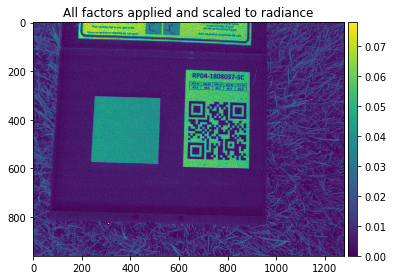

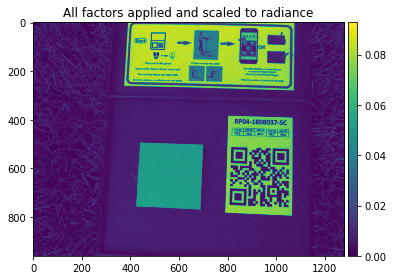

In [9]:
##Load in reflectance panel images using a CSV file for the panelcal
image_path = os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE', '07_23_TURF_DJI', '0000SET','PANEL')
panel_cal = load_panel_factors("C:/Users/Sara/panel_cal.csv")
panelimage(panel_cal,'IMG_0001_5.tif',image_path)
panelimage(panel_cal,'IMG_0248_2.tif',image_path)

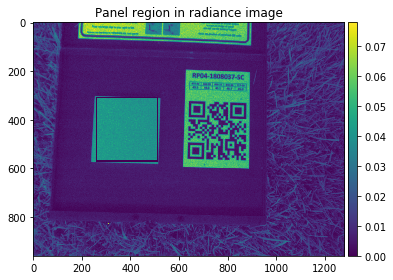

Mean Radiance in panel region: 0.041 W/m^2/nm/sr
Radiance to reflectance conversion factor: 11.957


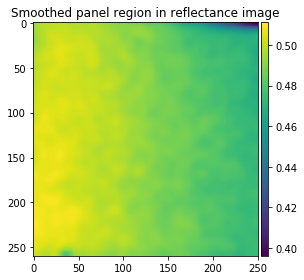

Min Reflectance in panel region: 0.13
Max Reflectance in panel region: 0.60
Mean Reflectance in panel region: 0.49
Standard deviation in region: 0.0245


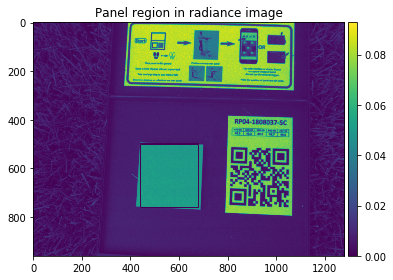

Mean Radiance in panel region: 0.051 W/m^2/nm/sr
Radiance to reflectance conversion factor: 9.582


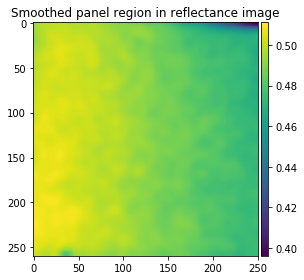

Min Reflectance in panel region: 0.07
Max Reflectance in panel region: 0.55
Mean Reflectance in panel region: 0.49
Standard deviation in region: 0.0213


10.76917592941538

In [10]:
##using the panel photos, calculate a radiance to reflectance value
##also returns stats for panel images, and bluring of panel region 
image_path = os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE', '07_23_TURF_DJI', '0000SET','PANEL')
radrefl_factor(panel_cal,'IMG_0001_5.tif','IMG_0248_2.tif',image_path,260,570,510,310,440,760,680,500, plot_steps=False,cal_model_fn=None, return_date=False)

In [ ]:
##run through the photos
##create output path for where you want photos to save to and how you want them named
inputpath = os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE','07_23_TURF_DJI', '0000SET', 'Flight','Band One')
outputpath = os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE', '07_23_TURF_DJI', '0000SET','Flight', 'Band One', 'Corrected')
files = os.listdir(os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE','07_23_TURF_DJI', '0000SET', 'Flight','Band One')) #the directory of images 
for imagefile in files: 
    if imagefile.endswith(".tif"):
        figname = imagefile[:-4] + '_corrected.tif'
        calibrate_correct_image(imagefile, inputpath, outputpath, figname, 10.76917592941538)

In [ ]:
inputpath = os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE','07_23_TURF_DJI', '0000SET', 'Flight','Band Two')
outputpath = os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE', '07_23_TURF_DJI', '0000SET','Flight', 'Band Two', 'Corrected')
files = os.listdir(os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE','07_23_TURF_DJI', '0000SET', 'Flight','Band Two')) #the directory of images 
for imagefile in files: 
    if imagefile.endswith(".tif"):
        figname = imagefile[:-4] + '_corrected.tif'
        calibrate_correct_image(imagefile, inputpath, outputpath, figname, 10.76917592941538)

In [13]:
inputpath = os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE','07_23_TURF_DJI', '0000SET', 'Flight','BandThree')
outputpath = os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE', '07_23_TURF_DJI', '0000SET','Flight', 'BandThree', 'Corrected')
files = os.listdir(os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE','07_23_TURF_DJI', '0000SET', 'Flight','BandThree'))
for imagefile in files: 
    if imagefile.endswith(".tif"):
        figname = imagefile[:-4] + '_corrected.tif'
        calibrate_correct_image(imagefile, inputpath, outputpath, figname, 10.76917592941538)

In [14]:
inputpath = os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE','07_23_TURF_DJI', '0000SET', 'Flight','Band Four')
outputpath = os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE', '07_23_TURF_DJI', '0000SET','Flight', 'Band Four', 'Corrected')
files = os.listdir(os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE','07_23_TURF_DJI', '0000SET', 'Flight','Band Four'))
for imagefile in files: 
    if imagefile.endswith(".tif"):
        figname = imagefile[:-4] + '_corrected.tif'
        calibrate_correct_image(imagefile, inputpath, outputpath, figname, 10.76917592941538)

In [ ]:
inputpath = os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE','07_23_TURF_DJI', '0000SET', 'Flight','Band Five')
outputpath = os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE', '07_23_TURF_DJI', '0000SET','Flight', 'Band Five', 'Corrected')
files = os.listdir(os.path.join('C:\\', 'Users', 'Sara', 'Pictures', 'MICASENSE','07_23_TURF_DJI', '0000SET', 'Flight','Band Five')) 
for imagefile in files: 
    if imagefile.endswith(".tif"):
        figname = imagefile[:-4] + '_corrected.tif'
        calibrate_correct_image(imagefile, inputpath, outputpath, figname, 10.76917592941538)